# Exploratory data analyses of the image data set IDR0033

----

This notebook can be used to preprocess the illumination corrected raw images obtained from [IDR0033](https://idr.openmicroscopy.org/webclient/?show=screen-1751) for the further analysis.

We will use available metadata to filter images that were manually identified by the authors of the [publication](https://elifesciences.org/articles/24060#s4) corresponding to the published imaging data as being outliers or that did not pass their quality control steps. For more information concerning the applied workflows to identify those, please refer to the publication.

---

## 0. Environmental setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import tifffile

from collections import Counter
from tqdm.notebook import tqdm
from shutil import copyfile
from skimage import (
    filters,
    morphology,
    measure,
    segmentation,
    exposure,
    feature,
    io,
    color,
)
import scipy.ndimage as ndi


sys.path.append("../../..")

from src.utils.basic.io import get_file_list
from src.utils.basic.visualization import (
    explore_samples_of_dataset,
    explore_segmentation_of_dataset,
)

# Load automatic code formatter (automatically executed when running a chunk)
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def rename_image_filenames(
    metadata,
    orig_col="Image_FileName_OrigHoechst",
    illum_col="Image_FileName_IllumHoechst",
    posfix="illum_corrected",
):
    orig_image_file_names = list(metadata[orig_col])
    illum_corrected_image_file_names = []
    for orig_image_file_name in orig_image_file_names:
        idx = orig_image_file_name.index(".")
        illum_corrected_image_file_name = (
            orig_image_file_name[:idx] + posfix + orig_image_file_name[idx:]
        )
        illum_corrected_image_file_names.append(illum_corrected_image_file_name)
    metadata[illum_col] = illum_corrected_image_file_names
    return metadata

<IPython.core.display.Javascript object>

In [3]:
def filter_out_qc_flagged_items(
    metadata,
    blurry_col="Image_Metadata_QCFlag_isBlurry",
    saturated_col="Image_Metadata_QCFlag_isSaturated",
):
    filtered_metadata = metadata.loc[
        (metadata[blurry_col] == 0) & (metadata[saturated_col] == 0)
    ]
    return filtered_metadata

<IPython.core.display.Javascript object>

In [4]:
def remove_outlier_items(
    metadata,
    outlier_plates=None,
    outlier_plate_wells=None,
    outlier_wells=None,
    plate_col="Image_Metadata_Plate",
    well_col="Image_Metadata_Well",
):
    metadata_orm = metadata.copy()
    if outlier_plates is not None:
        for outlier_plate in outlier_plates:
            metadata_orm = metadata_orm.loc[metadata_orm[plate_col] != outlier_plate]
    if outlier_plate_wells is not None:
        for outlier_plate_well in outlier_plate_wells:
            metadata_orm = metadata_orm.loc[
                (metadata_orm[plate_col] != outlier_plate_well[0])
                | (metadata_orm[well_col] != outlier_plate_well[1])
            ]
    if outlier_wells is not None:
        for outlier_well in outlier_wells:
            metadata_orm = metadata_orm.loc[metadata_orm[well_col] != outlier_well]
    return metadata_orm

<IPython.core.display.Javascript object>

In [5]:
def save_filtered_images(
    metadata,
    input_dir,
    output_dir,
    plate_col="Image_Metadata_Plate",
    illum_file_col="Image_FileName_IllumHoechst",
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    n = len(metadata)
    for i in tqdm(range(n), desc := "Copying images"):
        plate = metadata.iloc[i, list(metadata.columns).index(plate_col)]
        filename = metadata.iloc[i, list(metadata.columns).index(illum_file_col)]

        plate_output_dir = os.path.join(output_dir, str(plate))
        plate_input_dir = os.path.join(input_dir, str(plate))
        if not os.path.exists(plate_output_dir):
            os.makedirs(plate_output_dir)

        plate_output_file = os.path.join(plate_output_dir, filename)
        plate_input_file = os.path.join(plate_input_dir, filename)

        copyfile(plate_input_file, plate_output_file)
    print("Images (n={}) copied to {}.".format(len(metadata), output_dir))

<IPython.core.display.Javascript object>

In [6]:
def create_sample_segmentation_datasets(
    metadata,
    image_input_dir,
    outline_input_dir,
    n=10,
    plate_col="Image_Metadata_Plate",
    illum_file_col="Image_FileName_IllumHoechst",
    nuclei_outline_col="Image_FileName_NucleiOutlines",
    random_state=1234,
):
    sample_segmentation_datasets = {}
    sample_image_datasets = {}
    plates = np.unique(metadata.loc[:, plate_col])
    np.random.seed(random_state)
    for plate in plates:
        plate_segmentation_dataset = []
        plate_image_dataset = []
        plate_metadata = metadata.loc[metadata[plate_col] == plate]
        sample_idc = np.random.choice(len(plate_metadata), n)
        plate_image_dir = os.path.join(image_input_dir, str(plate))
        plate_outline_dir = os.path.join(outline_input_dir, str(plate))
        for idx in sample_idc:
            image_file_name = plate_metadata.iloc[idx, :][illum_file_col]
            image_file_path = os.path.join(plate_image_dir, image_file_name)
            print(image_file_path)
            outline_file_name = plate_metadata.iloc[idx, :][nuclei_outline_col]
            outline_file_path = os.path.join(plate_outline_dir, outline_file_name)

            image = io.imread(image_file_path)
            outlines = io.imread(outline_file_path)

            segmented_image = segment_image(outlines)
            plate_segmentation_dataset.append(segmented_image)
            plate_image_dataset.append(image)
        sample_image_datasets[str(plate)] = plate_image_dataset
        sample_segmentation_datasets[str(plate)] = plate_segmentation_dataset
    return sample_image_datasets, sample_segmentation_datasets

<IPython.core.display.Javascript object>

In [7]:
def segment_image(contour_image):
    binary = ndi.binary_fill_holes(contour_image)
    binary[contour_image != 0] = 0
    labeled = measure.label(binary)
    return labeled

<IPython.core.display.Javascript object>

In [8]:
def segment_images_and_get_nuclei_metadata(
    metadata,
    image_input_dir,
    outline_input_dir,
    output_dir,
    plate_col="Image_Metadata_Plate",
    illum_file_col="Image_FileName_IllumHoechst",
    nuclei_outline_col="Image_FileName_NucleiOutlines",
    nuclei_count_col="Image_Count_Nuclei",
    min_area=1,
    max_area=1e8,
    max_eccentricity=1,
    min_solidity=0,
):
    nuclei_metadata = []
    image_metadata = metadata.copy()

    metadata_cols = list(metadata.columns)
    max_width = 0
    max_length = 0

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in tqdm(range(len(metadata))):
        plate = str(metadata.iloc[i, :][plate_col])

        image_file_name = metadata.iloc[i, :][illum_file_col]
        image_file_path = os.path.join(input_dir, plate, image_file_name)
        image = tifffile.imread(image_file_path)

        outline_file_name = metadata.iloc[i, :][nuclei_outline_col]
        outline_file_path = os.path.join(outline_input_dir, plate, outline_file_name)
        outline_image = io.imread(outline_file_path)

        label_image = segment_image(outline_image)

        label_image = morphology.remove_small_objects(label_image, min_size=min_area)

        image_metadata.iloc[i, metadata_cols.index(nuclei_count_col)] = len(
            np.unique(label_image)
        )

        regions = measure.regionprops(label_image=label_image, intensity_image=image)
        for region in regions:
            width, length = region.image.shape

            fname_start = image_file_name[: image_file_name.index(".")]
            fname_ending = image_file_name[image_file_name.index(".") :]
            plate_output_dir = os.path.join(output_dir, plate)

            if not os.path.exists(plate_output_dir):
                os.makedirs(plate_output_dir)

            if (
                width * length < max_area
                and region.eccentricity < max_eccentricity
                and region.solidity > min_solidity
            ):

                max_width = max(max_width, width)
                max_length = max(max_length, length)

                output_file_name = os.path.join(
                    plate_output_dir,
                    fname_start + "_{}".format(region.label) + fname_ending,
                )

                cropped = region.intensity_image

                tifffile.imsave(output_file_name, cropped)
                nucleus_metadata = list(metadata.iloc[i, :])
                nucleus_metadata[metadata_cols.index(illum_file_col)] = os.path.split(
                    output_file_name
                )[1]
                nuclei_metadata.append(nucleus_metadata)
    nuclei_metadata = pd.DataFrame(np.array(nuclei_metadata), columns=metadata_cols)
    nuclei_metadata = nuclei_metadata.loc[
        :,
        [
            "Image_Metadata_Plate",
            "Image_Metadata_Well",
            "Image_FileName_IllumHoechst",
            "Image_Metadata_GeneID",
            "Image_Metadata_GeneSymbol",
            "Image_Metadata_IsLandmark",
            "Image_Metadata_AlleleDesc",
            "Image_Metadata_ExpressionVector",
            "Image_Metadata_FlaggedForToxicity",
            "Image_Metadata_IE_Blast_noBlast",
            "Image_Metadata_IntendedOrfMismatch",
            "Image_Metadata_OpenOrClosed",
            "Image_Metadata_RNAiVirusPlateName",
            "Image_Metadata_Site",
            "Image_Metadata_Type",
            "Image_Metadata_Virus_Vol_ul",
            "Image_Metadata_TimePoint_Hours",
            "Image_Metadata_ASSAY_WELL_ROLE",
        ],
    ]
    nuclei_metadata.columns = [
        "plate",
        "well",
        "image_file",
        "gene_id",
        "gene_symbol",
        "is_landmark",
        "allele",
        "expr_vec",
        "toxicity",
        "ie_blast",
        "intended_orf_mismatch",
        "open_closed",
        "rnai_plate",
        "site",
        "type",
        "virus_vol",
        "timepoint",
        "assay_well_role",
    ]
    print(
        "Nuclei segmentation complete: max dimensions ({}, {})".format(
            max_width, max_length
        )
    )
    return nuclei_metadata, image_metadata

<IPython.core.display.Javascript object>

In [9]:
def create_nuclei_sample_datasets(
    nuclei_metadata,
    input_dir,
    n=2500,
    image_file_col="image_file",
    plate_col="plate",
    random_state=1234,
):
    nuclei_sample_datasets = {}
    plates = np.unique(nuclei_metadata[plate_col])
    np.random.seed(random_state)
    for plate in plates:
        plate_dataset = []
        plate_nuclei_metadata = nuclei_metadata.loc[
            nuclei_metadata[plate_col] == plate, :
        ]
        sample_idc = np.random.choice(len(plate_nuclei_metadata), size=n)
        for idx in sample_idc:
            file_path = os.path.join(
                input_dir,
                str(plate),
                plate_nuclei_metadata.iloc[idx, :][image_file_col],
            )
            plate_dataset.append(tifffile.imread(file_path))
        nuclei_sample_datasets[plate] = plate_dataset
    return nuclei_sample_datasets

<IPython.core.display.Javascript object>

In [10]:
def plot_datasets_as_image_grid(datasets, dataset_id=0, cmap="seismic"):
    dataset = datasets[list(datasets.keys())[dataset_id]]
    n = np.sqrt(len(dataset))
    fig, ax = plt.subplots(nrows=int(n), ncols=int(n), figsize=[20, 20])
    ax = ax.flatten()
    for i in range(len(ax)):
        padded_img = pad_image(dataset[i], [91, 91])
        ax[i].imshow(padded_img, cmap=cmap)
        ax[i].axis("off")
    plt.show()

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in the metadata information that provide information about e.g. which images correspond to which plate, well combination and which gene was targeted. The respective file was exported from a database for which the corresponding sql script has been published alongside with the imaging data. Please refer to the github repo of the original publication for more information of how to set up the database. To derive the metadata file load in in the following, we provide a custom sql-file (`extract_metadata.sql`).

In [11]:
metadata = pd.read_csv("../../../data/images/metadata/metadata_images.csv")
metadata.head()

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,41744_IllumHoechst.mat,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,41744_IllumHoechst.mat,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,41744_IllumHoechst.mat,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,41744_IllumHoechst.mat,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,41744_IllumHoechst.mat,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

In [12]:
metadata.columns

Index(['ImageNumber', 'Image_Metadata_Plate', 'Image_Metadata_Well',
       'Image_FileName_OrigHoechst', 'Image_FileName_IllumHoechst',
       'Image_FileName_NucleiOutlines', 'Image_Count_Nuclei',
       'Image_Metadata_GeneID', 'Image_Metadata_GeneSymbol',
       'Image_Metadata_IsLandmark', 'Image_Metadata_AlleleDesc',
       'Image_Metadata_ExpressionVector', 'Image_Metadata_FlaggedForToxicity',
       'Image_Metadata_IE_Blast_noBlast', 'Image_Metadata_IntendedOrfMismatch',
       'Image_Metadata_OpenOrClosed', 'Image_Metadata_RNAiVirusPlateName',
       'Image_Metadata_Site', 'Image_Metadata_TimePoint_Hours',
       'Image_Metadata_Type', 'Image_Metadata_Virus_Vol_ul',
       'Image_Metadata_ASSAY_WELL_ROLE', 'Image_Metadata_QCFlag_isBlurry',
       'Image_Metadata_QCFlag_isSaturated'],
      dtype='object')

<IPython.core.display.Javascript object>

As suggested in the original publication we will be working with the image that were corrected for different illumination conditions that is also available.

We will now adapt the `Image_FileName_OrigHoechst` entries in the metadata dataframe by the posfix `_illum_corrected` to ensure that the column represents the actual filenames of `.tif` images that we will be working with.

In [13]:
posfix = "_illum_corrected"
orig_col = "Image_FileName_OrigHoechst"
illum_col = "Image_FileName_IllumHoechst"

metadata = rename_image_filenames(
    metadata, orig_col=orig_col, illum_col=illum_col, posfix=posfix
)
metadata.head()

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

---

## 2. Data filtering

### 2a. Filter out blurry or saturated images

Next, we will filter out images that were identified to be blurry or saturated and thus not passing the standards for the image quality that we take over from the authors of the original publication. The respective information are also available in the metadata.

In [14]:
blurry_col = "Image_Metadata_QCFlag_isBlurry"
saturated_col = "Image_Metadata_QCFlag_isSaturated"

filtered_metadata = filter_out_qc_flagged_items(
    metadata, blurry_col=blurry_col, saturated_col=saturated_col
)
filtered_metadata.head()

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

In [15]:
print(
    "Images filtered out for not passing the quality standards: {}.".format(
        len(metadata) - len(filtered_metadata)
    )
)

Images filtered out for not passing the quality standards: 251.


<IPython.core.display.Javascript object>

As seen above 251 images were identified to be either blurry or saturated and thus should be excluded for the downstream analysis.

---

### 2b. Filter out outlier images (manual selection)

In addition to the images that were flagged for not passing the quality control steps the authors further excluded 2 additional plate-well combinations and one complete plate during their analyses as they identified those by visual inspection as outliers.

Those are the following:
* Plate 41749 (all wells)
* Plate 41754 (well B01)
* Plate 41757 (well E17)

Unfortunately, no description is given which criteria was used to identify these outliers. When briefly looking at the data in the [IDR webclient](https://idr.openmicroscopy.org/webclient/?show=screen-1751) we do not see any remarkable abnormalities.

Nonetheless, we derive the subset of the dataset where we filter out the corresponding items of these plate-well combinations to follow the preprocessing steps of the original publication.

Additionally, we identify a number of images that show artifacts which are likely to confound our downstream analyses. Among those are some plate-well combinations that are out of focus but not identified before by the authors.

These are the following:

* Plate 41754 (well C01, D01, E01 and F01)

We also exclude those wells, if we exclude additional slide images that we saw to include imaging artifacts such as tissue fibers or illumination failures is yet to be determined.

In [16]:
outlier_plates = [41749]
outlier_plate_wells = [
    [41754, "b01"],
    [41754, "c01"],
    [41754, "d01"],
    [41754, "e01"],
    [41754, "f01"],
    [41757, "e17"],
]
outlier_wells = []
plate_col = "Image_Metadata_Plate"
well_col = "Image_Metadata_Well"


filtered_metadata_orm = remove_outlier_items(
    metadata,
    outlier_plates=outlier_plates,
    outlier_plate_wells=outlier_plate_wells,
    outlier_wells=outlier_wells,
    plate_col=plate_col,
    well_col=well_col,
)
filtered_metadata_orm.head()

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

After the filtering we are left with 1,918 unique plate-well combinations for each 9 fields of view are available leading to a total of 17,262 images. Surprisingly, those are 36 images (4 plate-well) more than what is described in the publication to be the final result of the preprocessing of the images. 

While our segmentation pipeline will differ from the ones the authors used to segment the nuclei, we can get also a first feeling of the dimension of the single-nuclei imaging dataset that we will be working with using the available metadata.

In [17]:
np.sum(list(filtered_metadata_orm["Image_Count_Nuclei"])), len(
    np.unique(filtered_metadata_orm["Image_Metadata_GeneSymbol"])
)

(1273345, 194)

<IPython.core.display.Javascript object>

The authors obtained roughly 1,28 million nuclei corresponding to ORF overexpression of 193 genes respectively the control condition. The total number of nuclei for each condition differs quite a bit, which is also due to the fact that we have more plate-well combinations for some genes than for others.

In [36]:
filtered_metadata_orm.loc[
    filtered_metadata_orm["Image_Metadata_GeneSymbol"] == "CDKN1A"
].head(50)

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
2792,7096,41754,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s4_w17f74...,taoe005-u2os-72h-cp-a-au00044858_a21_s4_w17f74...,a21_s4_NucleiOutlines.png,11,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2838,7101,41754,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s9_w116d8...,taoe005-u2os-72h-cp-a-au00044858_a21_s9_w116d8...,a21_s9_NucleiOutlines.png,63,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3004,7093,41754,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s1_w1d4ab...,taoe005-u2os-72h-cp-a-au00044858_a21_s1_w1d4ab...,a21_s1_NucleiOutlines.png,12,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,1,72H,ORF OE,1,Treated,0,0
3186,7099,41754,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s7_w159a2...,taoe005-u2os-72h-cp-a-au00044858_a21_s7_w159a2...,a21_s7_NucleiOutlines.png,56,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
4857,10552,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s4_w144e5...,taoe005-u2os-72h-cp-a-au00044858_a21_s4_w144e5...,a21_s4_NucleiOutlines.png,37,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
4994,10551,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s3_w14e22...,taoe005-u2os-72h-cp-a-au00044858_a21_s3_w14e22...,a21_s3_NucleiOutlines.png,36,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,3,72H,ORF OE,1,Treated,0,0
5173,10556,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s8_w14def...,taoe005-u2os-72h-cp-a-au00044858_a21_s8_w14def...,a21_s8_NucleiOutlines.png,59,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,8,72H,ORF OE,1,Treated,0,0
5179,10555,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s7_w139ed...,taoe005-u2os-72h-cp-a-au00044858_a21_s7_w139ed...,a21_s7_NucleiOutlines.png,61,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
5341,10549,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s1_w1f7ae...,taoe005-u2os-72h-cp-a-au00044858_a21_s1_w1f7ae...,a21_s1_NucleiOutlines.png,12,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,1,72H,ORF OE,1,Treated,0,0
5827,10550,41755,a21,taoe005-u2os-72h-cp-a-au00044858_a21_s2_w1c8fb...,taoe005-u2os-72h-cp-a-au00044858_a21_s2_w1c8fb...,a21_s2_NucleiOutlines.png,39,1026.0,CDKN1A,1.0,...,NaN,open,ORA11.12.13.18A,2,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

In [18]:
Counter(filtered_metadata_orm["Image_Metadata_GeneSymbol"])

Counter({'EIF4E': 90,
         'DKK1': 45,
         'ATF6': 135,
         'FURIN': 90,
         'MAPK8': 90,
         'CARD11': 135,
         'ATG16L1': 45,
         'TSC1': 90,
         'PAK1': 90,
         'XBP1': 180,
         'PRKAA1': 90,
         'MAP3K9': 45,
         'IKBKE': 90,
         'TGFBR1': 180,
         'RIPK1': 45,
         'EMPTY': 1557,
         'PSENEN': 45,
         'BRAF': 135,
         'DVL1': 90,
         'PER1': 90,
         'EGLN1': 135,
         'MOS': 90,
         'BMPR1B': 180,
         'Luciferase': 360,
         'CCND1': 90,
         'DVL3': 45,
         'TBK1': 90,
         'PIK3R1': 90,
         'PRKACA': 90,
         'NOTCH1': 135,
         'DEPTOR': 90,
         'TRAF6': 90,
         'PRKCZ': 180,
         'PRKACB': 135,
         'PRKACG': 135,
         'DIABLO': 45,
         'CHUK': 90,
         'LRPPRC': 45,
         'SLIRP': 90,
         'MKNK1': 45,
         'RAF1': 135,
         'GLI1': 45,
         'CYLD': 90,
         'JAK2': 90,
         'PKI

<IPython.core.display.Javascript object>

---

## 3. Save filtered image data

Previously we filtered the metadata to exclude images not passing the quality control standards established by Rohban et al. (2017). We will now use this subset and store the Hoechst(DNA) stained images individually. This is because a) we can drastically reduce the size of the overall dataset in terms of storage requirements and going forward we are only interested in this staining.

In [25]:
output_dir = "../../../data/images/filtered"
input_dir = "../../../data/images/data"
plate_col = "Image_Metadata_Plate"
illum_file_col = "Image_FileName_IllumHoechst"

# save_filtered_images(
#     filtered_metadata_orm,
#     input_dir=input_dir,
#     output_dir=output_dir,
#     plate_col=plate_col,
#     illum_file_col=illum_file_col,
# )

<IPython.core.display.Javascript object>

We will also store the filtered metadata along side with the images.

In [ ]:
filtered_metadata_orm.to_csv()

---

## 4. Nuclei segmentation

After the previously described filtering steps we will now turn to the segmentation of the invidiual nuclei as we will be working on single nuclei images. In addition to the raw images the authors also provide contour lines for the individual nuclei as segmented by their computational pipeline. We will use those and hence use their segmentation to save us from finetuning a segmentation pipeline as well as in order to be consistent with their preprocessing pipeline.

### 4.1. Visualize the segmentation

Before we use the given data to segment the individual nuclei we first provide some example of the segmentation to show that it accurately captures the nuclei. To this end, we will randomly sample n=10 images from each plate and overlay the segmentation based on the provided contour lines with the raw input image to show the segmentation.

In [27]:
n = 10
image_input_dir = "../../../data/images/filtered"
outline_input_dir = "../../../data/images/segmented_outlines"

(
    image_sample_datasets,
    segmentation_sample_datasets,
) = create_sample_segmentation_datasets(
    metadata=filtered_metadata_orm,
    image_input_dir=image_input_dir,
    outline_input_dir=outline_input_dir,
    n=n,
    plate_col="Image_Metadata_Plate",
    illum_file_col="Image_FileName_IllumHoechst",
    nuclei_outline_col="Image_FileName_NucleiOutlines",
    random_state=1234,
)

../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_j16_s5_w15b754175-cb11-4c7f-a2d4-c000f40f0e1e_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_b23_s2_w16bf3da15-cf04-47af-8408-d06ecf7e58ef_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_a12_s1_w115408628-497a-4200-b146-774a95872769_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_m05_s1_w12ab9d735-7a94-47ae-8313-f8a979f23238_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_m15_s2_w1eb564803-589d-41eb-b9b5-ac7e5fa316ce_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_p06_s3_w1611cb4ff-9659-4e4c-9703-5bcb063345e2_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_a03_s3_w10459267e-14ca-4ef7-8171-53b26dad0f26_illum_corrected.tif
../../../data/images/filtered/41744/taoe005-u2os-72h-cp

<IPython.core.display.Javascript object>

----

#### Segmented 41744

In [28]:
explore_segmentation_of_dataset(
    image_sample_datasets, segmentation_sample_datasets, dataset_id=0, cmap="seismic"
)

interactive(children=(IntSlider(value=0, description='plane', max=9), Output()), _dom_classes=('widget-interac…

<function src.utils.basic.visualization.explore_segmentation_of_dataset.<locals>.display_slice(plane=0)>

<IPython.core.display.Javascript object>

---

#### Segmented 41754

In [28]:
explore_segmentation_of_dataset(
    image_sample_datasets, segmentation_sample_datasets, dataset_id=1, cmap="seismic"
)

interactive(children=(IntSlider(value=0, description='plane', max=9), Output()), _dom_classes=('widget-interac…

<function src.utils.basic.visualization.explore_segmentation_of_dataset.<locals>.display_slice(plane=0)>

<IPython.core.display.Javascript object>

----

#### Segmented 41755

In [29]:
explore_segmentation_of_dataset(
    image_sample_datasets, segmentation_sample_datasets, dataset_id=2, cmap="seismic"
)

interactive(children=(IntSlider(value=0, description='plane', max=9), Output()), _dom_classes=('widget-interac…

<function src.utils.basic.visualization.explore_segmentation_of_dataset.<locals>.display_slice(plane=0)>

<IPython.core.display.Javascript object>

----

#### Segmented 41744

In [30]:
explore_segmentation_of_dataset(
    image_sample_datasets, segmentation_sample_datasets, dataset_id=3, cmap="seismic"
)

interactive(children=(IntSlider(value=0, description='plane', max=9), Output()), _dom_classes=('widget-interac…

<function src.utils.basic.visualization.explore_segmentation_of_dataset.<locals>.display_slice(plane=0)>

<IPython.core.display.Javascript object>

----

#### Segmented 41757

In [31]:
explore_segmentation_of_dataset(
    image_sample_datasets, segmentation_sample_datasets, dataset_id=4, cmap="seismic"
)

interactive(children=(IntSlider(value=0, description='plane', max=9), Output()), _dom_classes=('widget-interac…

<function src.utils.basic.visualization.explore_segmentation_of_dataset.<locals>.display_slice(plane=0)>

<IPython.core.display.Javascript object>

The above segmentation looks fine and hence we will use that pipeline to segment all images.

---

### 4.3. Segment and save images


During the segmentation we will ensure to maintain the available metadata including i.a. the gene targets, well and plate number for each nucleus by constructing a new metadata file. Those information will be important for our downstream analyses.

In [14]:
output_dir = "../data/images/single_nuclei_min_area_400_max_bbarea_4000_max_ecc_95_min_solidity_90"

<IPython.core.display.Javascript object>

In [189]:
nuclei_metadata, image_metadata = segment_images_and_get_nuclei_metadata(
    metadata=filtered_metadata_orm,
    image_input_dir=image_input_dir,
    outline_input_dir=outline_input_dir,
    output_dir=os.path.join(output_dir, "images"),
    plate_col="Image_Metadata_Plate",
    illum_file_col="Image_FileName_IllumHoechst",
    nuclei_outline_col="Image_FileName_NucleiOutlines",
    nuclei_count_col="Image_Count_Nuclei",
    min_area=400,
    max_area=4000,
    max_eccentricity=0.95,
    min_solidity=0.9,
)
nuclei_metadata.to_csv(os.path.join(output_dir, "nuclei_metadata.csv"))
image_metadata.to_csv(os.path.join(output_dir, "image_metadata.csv"))

  0%|          | 0/17262 [00:00<?, ?it/s]

<ipython-input-188-17e2f7cdb7d9>:38: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  label_image = morphology.remove_small_objects(label_image, min_size=min_area)


Nuclei segmentation complete: max dimensions (91, 91)


<IPython.core.display.Javascript object>

In [190]:
nuclei_metadata

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,intended_orf_mismatch,open_closed,rnai_plate,site,type,virus_vol,timepoint,assay_well_role
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,nan,0.91,nan,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,nan,0.91,nan,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,nan,0.91,nan,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,nan,0.91,nan,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,nan,0.91,nan,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056011,41744,n22,taoe005-u2os-72h-cp-a-au00044859_n22_s3_w1e0fd...,57521.0,RPTOR,0.0,WT,pLX304,nan,0.84,nan,open,ORA11.12.13.18A,3,ORF OE,1,72H,Treated
1056012,41744,n22,taoe005-u2os-72h-cp-a-au00044859_n22_s3_w1e0fd...,57521.0,RPTOR,0.0,WT,pLX304,nan,0.84,nan,open,ORA11.12.13.18A,3,ORF OE,1,72H,Treated
1056013,41744,n22,taoe005-u2os-72h-cp-a-au00044859_n22_s3_w1e0fd...,57521.0,RPTOR,0.0,WT,pLX304,nan,0.84,nan,open,ORA11.12.13.18A,3,ORF OE,1,72H,Treated
1056014,41744,n22,taoe005-u2os-72h-cp-a-au00044859_n22_s3_w1e0fd...,57521.0,RPTOR,0.0,WT,pLX304,nan,0.84,nan,open,ORA11.12.13.18A,3,ORF OE,1,72H,Treated


<IPython.core.display.Javascript object>

In [20]:
image_metadata = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/images/8bit_min_max_96pad/image_metadata.csv",
    index_col=0,
)

<IPython.core.display.Javascript object>

In [39]:
np.where(
    np.array(image_metadata.loc[:, "nuclei_count"])
    != np.array(filtered_metadata_orm.loc[:, "Image_Count_Nuclei"])
)

<ipython-input-39-0f0ab1d489ea>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(image_metadata.loc[:, "nuclei_count"]) !=


(array([0]),)

<IPython.core.display.Javascript object>

In [30]:
import scipy

scipy.stats.describe(
    list(
        (
            image_metadata.loc[:, "nuclei_count"]
            - filtered_metadata_orm.loc[:, "Image_Count_Nuclei"]
        )
    )
)

DescribeResult(nobs=17226, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

<IPython.core.display.Javascript object>

While reuse the segmentation from the authors of the original publication introducing this dataset we apply some area-based and eccentricity-based filtering to remove some segmentation artifacts. This cuts down the number of identified nuclei objects by roughly 190'000 which corresponds to an average decrease of 9.6223 nuclei per image.

---

### 4.4. Visualization of the segmented images

In the following we will visualize 2500 randomly selected nuclei from each plate to provide an overview of the data.

In [15]:
nuclei_metadata = pd.read_csv(
    os.path.join(output_dir, "nuclei_metadata.csv"), index_col=0
)

/home/paysan_d/miniconda3/envs/img2reg/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<IPython.core.display.Javascript object>

In [70]:
sample_nuclei_datasets = create_nuclei_sample_datasets(
    nuclei_metadata, input_dir=os.path.join(output_dir, "images"), n=100
)

<IPython.core.display.Javascript object>

In [17]:
sample_nuclei_datasets.keys()

dict_keys([41744, 41754, 41755, 41756, 41757])

<IPython.core.display.Javascript object>

#### 41744

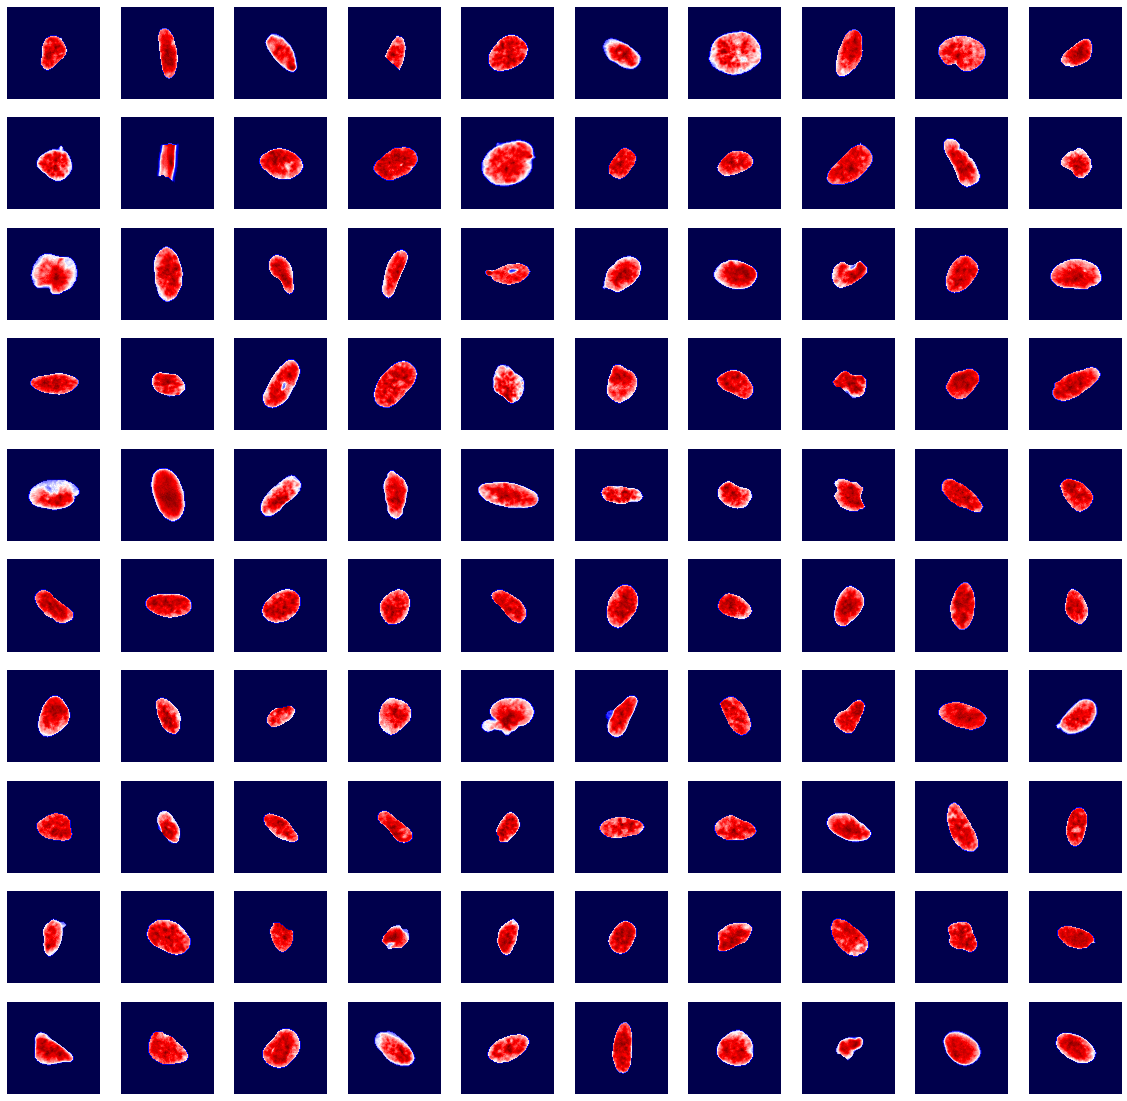

<IPython.core.display.Javascript object>

In [72]:
plot_datasets_as_image_grid(sample_nuclei_datasets)

---

#### 41754

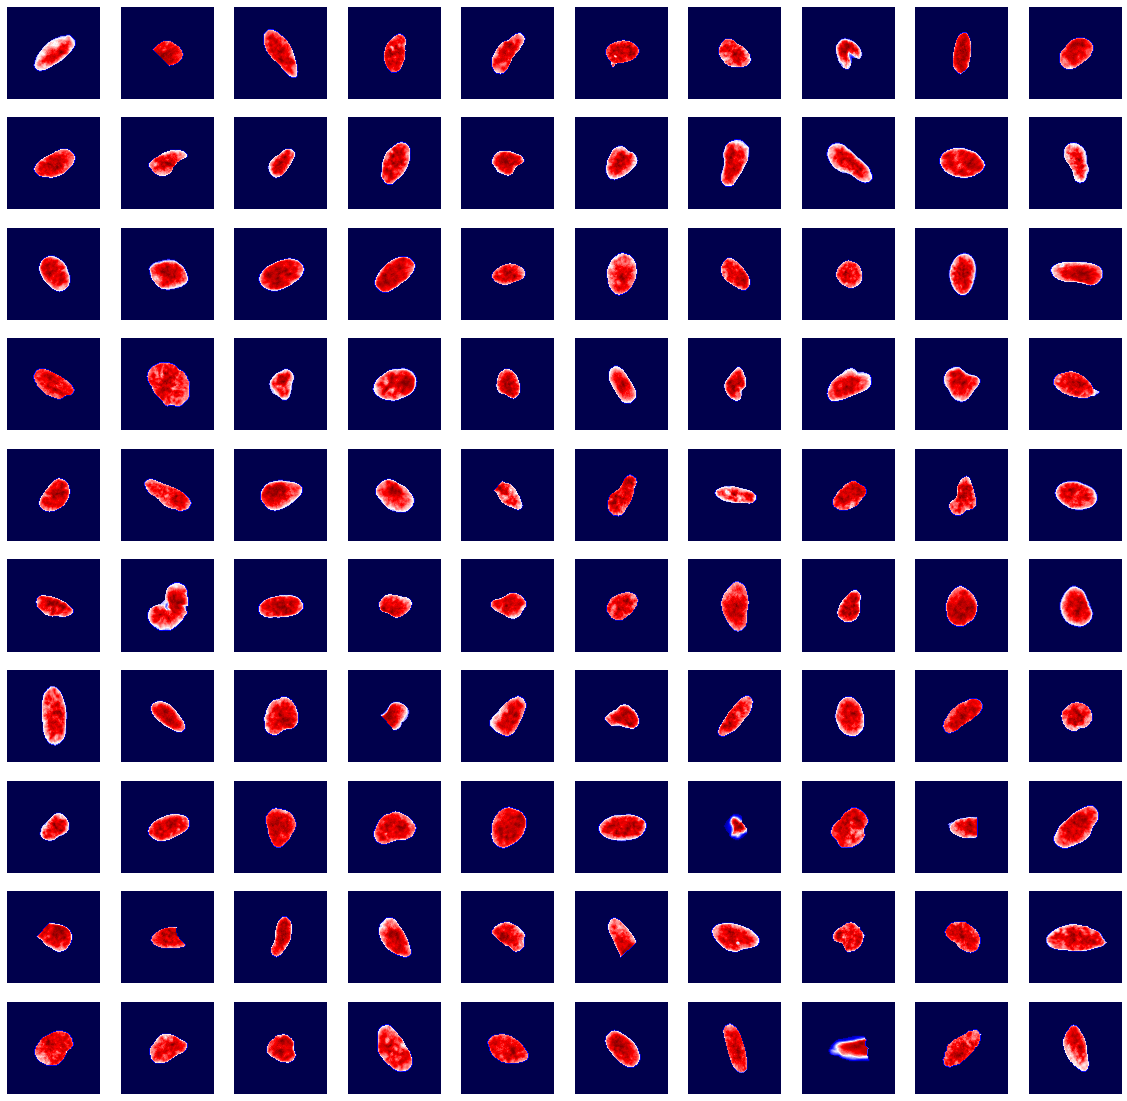

<IPython.core.display.Javascript object>

In [73]:
plot_datasets_as_image_grid(sample_nuclei_datasets, dataset_id=1)

---

#### 41755

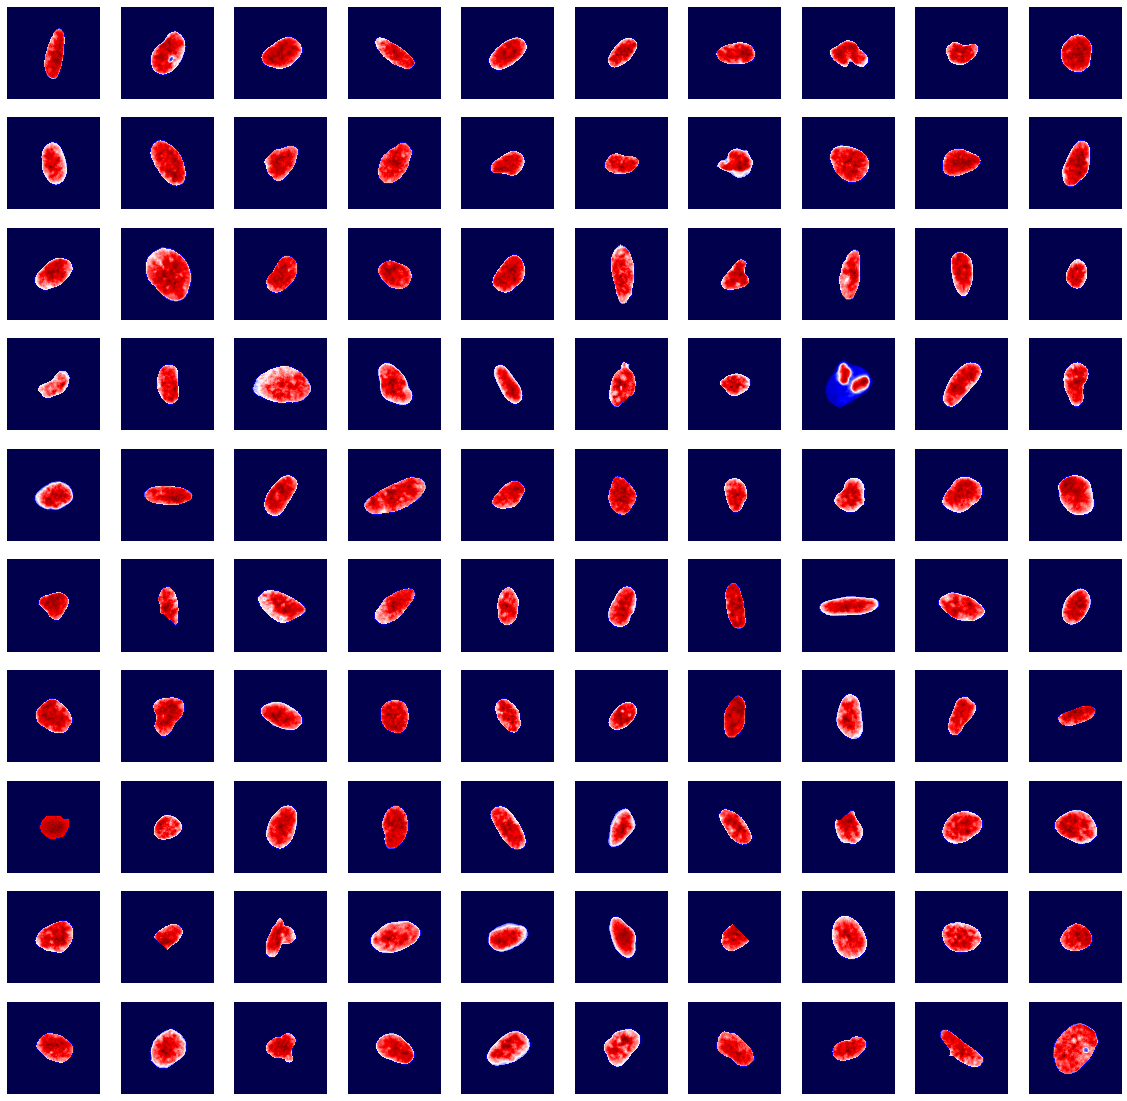

<IPython.core.display.Javascript object>

In [74]:
plot_datasets_as_image_grid(sample_nuclei_datasets, dataset_id=2)

---

#### 41756

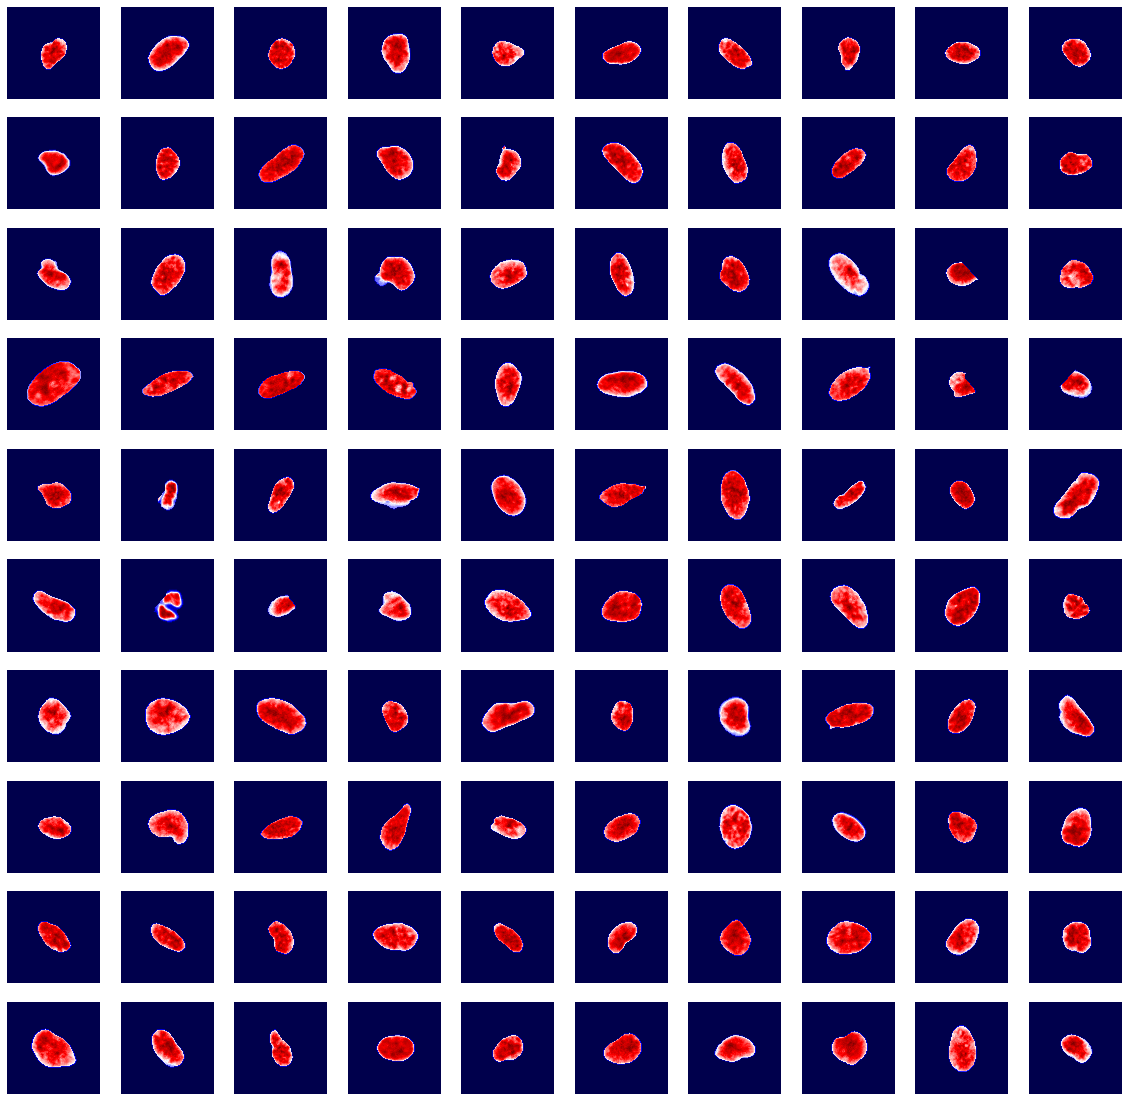

<IPython.core.display.Javascript object>

In [75]:
plot_datasets_as_image_grid(sample_nuclei_datasets, dataset_id=3)

---

#### 41757

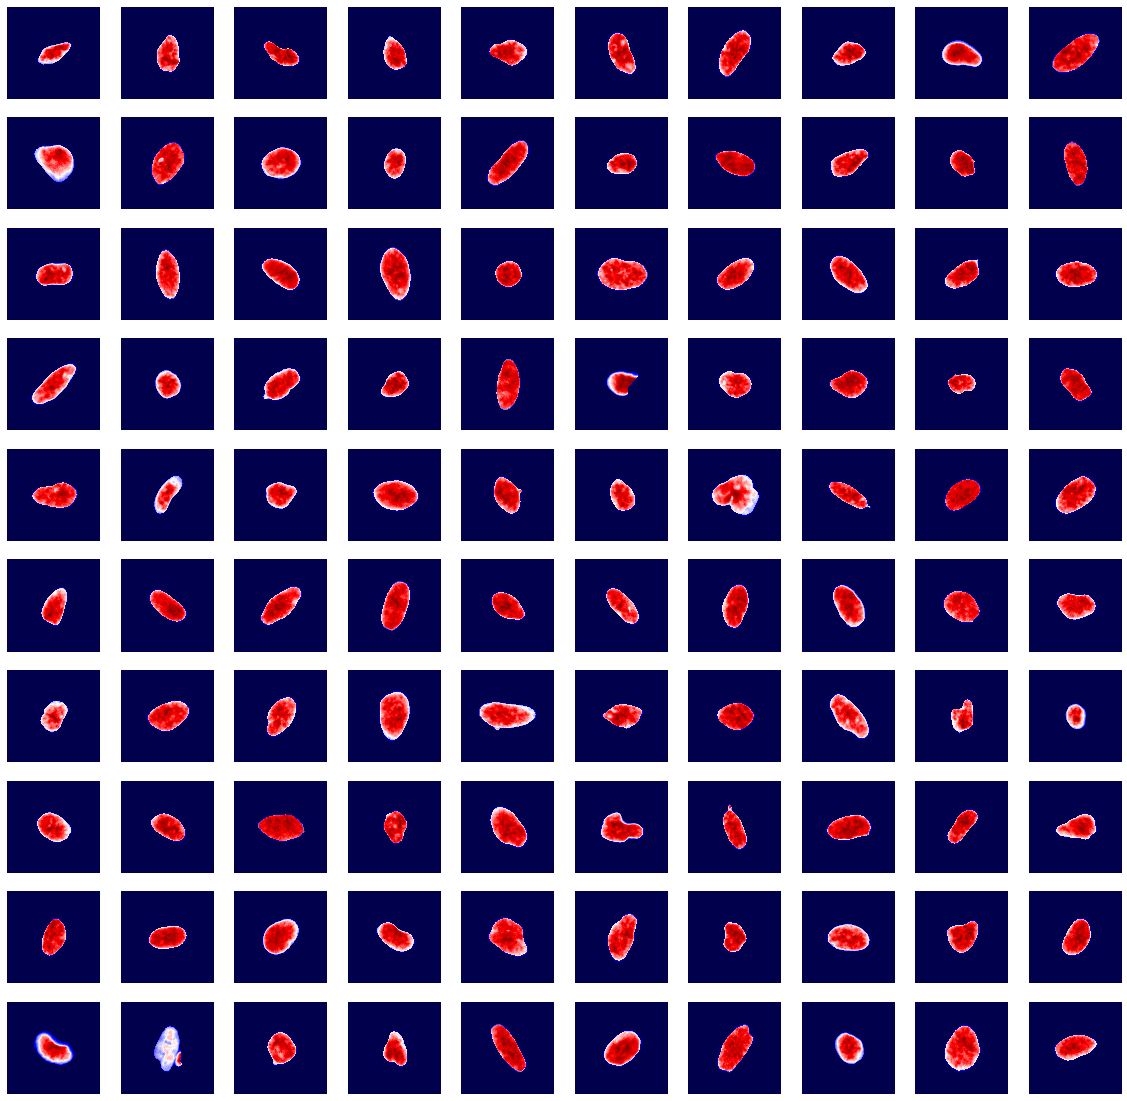

<IPython.core.display.Javascript object>

In [76]:
plot_datasets_as_image_grid(sample_nuclei_datasets, dataset_id=4)

---

### 4.5. Pad images

Our downstream analyses will require the images to be of equal shapes which is not the case at the time being as shown in the grid images above. We will now pad the images such that each images is a square image of 91px in length. We have chosen 91 as this was determined to be the maximum width and length of all segmented nuclei images.

In [62]:
image = sample_nuclei_datasets[41754][4]

<IPython.core.display.Javascript object>

In [35]:
img_size = image.shape

<IPython.core.display.Javascript object>

In [36]:
size = [91, 91]

<IPython.core.display.Javascript object>

In [37]:
padded_img = np.zeros(size)

<IPython.core.display.Javascript object>

In [38]:
xmid = size[0] // 2 + 1
ymid = size[1] // 2 + 1

<IPython.core.display.Javascript object>

In [39]:
xhalf_img = img_size[0] // 2
yhalf_img = img_size[1] // 2

<IPython.core.display.Javascript object>

In [40]:
padded_img[
    xmid - xhalf_img : xmid + (img_size[0] - xhalf_img),
    ymid - yhalf_img : ymid + (img_size[1] - yhalf_img),
] = image

<IPython.core.display.Javascript object>

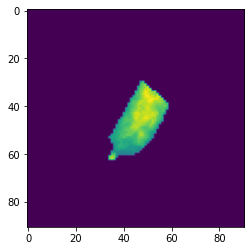

<IPython.core.display.Javascript object>

In [65]:
plt.imshow(pad_image(image, size))

In [64]:
def pad_image(image, size):
    padded_img = np.zeros(size)
    img_x, img_y = image.shape
    pimg_x, pimg_y = padded_img.shape

    pimg_xmid = pimg_x // 2 + pimg_x % 2
    pimg_ymid = pimg_y // 2 + pimg_y % 2

    img_xhalf = img_x // 2
    img_yhalf = img_y // 2

    padded_img[
        pimg_xmid - img_xhalf : pimg_xmid + (img_x - img_xhalf),
        pimg_ymid - img_yhalf : pimg_ymid + (img_y - img_yhalf),
    ] = image
    return padded_img

<IPython.core.display.Javascript object>